### Instalando versão 0.28 do sdk da OpenAI

In [ ]:
pip install openai==0.28

### Importando bibliotecas

In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import openai
from google.colab import userdata

### Carregando Dataset

In [ ]:
with open('/content/review_data_Cyberpunk_2077.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

X = [item['review'] for item in data]
y = [1 if item['rating'] == 'recomendado' else 0 for item in data]  # 1 para recomendado, 0 caso contrário

_, X_test, _, y_test = train_test_split(X, y, test_size=0.30, random_state=11)

data_test = []

for x, y in zip(X_test, y_test):
  item = {}
  item['review'] = x
  item['rating'] = y
  item['llm_rating'] = None
  data_test.append(item)

### Acessando API da OpenAI, e a utilizando como classificador de reviews no conjunto de testes
referência: https://platform.openai.com/docs/guides/text-generation

In [ ]:
openai.api_key = userdata.get('api_key')

def classify_review(review, model="gpt-3.5-turbo"):
    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {
                    "role": "system",
                    "content": "You are a sentiment classifier for reviews of the game Cyberpunk 2077. Classify them as positive or negative.",
                },
                {
                    "role": "user",
                    "content": f"""
                    Review:
                        {review}
                    Respond only with a number: 1 for positive, 0 for negative.
                    """,
                },
            ],
            max_tokens=5,
            temperature=0.3,
        )
        return response.choices[0].message['content'].strip()
    except Exception as e:
        print(f"Error classifying the review: {e}")
        return None

y_pred = []

for item in data_test:
  try:
    y_result = classify_review(item['review'])
    item['llm_rating'] = int(y_result)
  except Exception as e:
    print(f"Error classifying the review: {e}")

Error classifying the review: invalid literal for int() with base 10: "I'm sorry, I"
Error classifying the review: invalid literal for int() with base 10: "I'm sorry, I"
Error classifying the review: invalid literal for int() with base 10: "I'm sorry, but"


In [ ]:
data_test = [item for item in data_test if item['llm_rating'] is not None]
y_test = [item['rating'] for item in data_test]
y_pred = [item['llm_rating'] for item in data_test]

In [ ]:
# Gerar matriz de confusão
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusão')
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Verdadeira')
    plt.show()

### Métricas com in-context learning

                 precision    recall  f1-score   support

não recomendado       0.76      0.98      0.86       603
    recomendado       0.98      0.69      0.81       594

       accuracy                           0.84      1197
      macro avg       0.87      0.83      0.83      1197
   weighted avg       0.87      0.84      0.83      1197



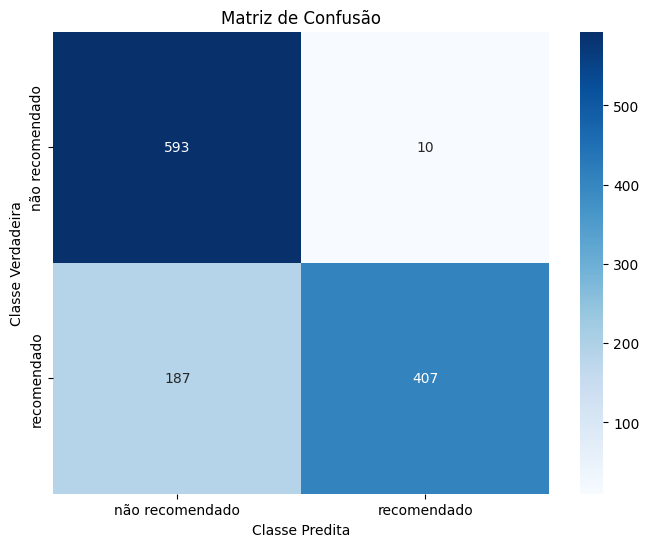

In [ ]:
print(classification_report(y_test, y_pred, target_names=['não recomendado', 'recomendado']))

plot_confusion_matrix(y_test, y_pred, ['não recomendado', 'recomendado'])